**Nome:** Pedro Henrique Silva Domingues

**R.A.:** 122.103-5

### Bibliotecas

In [2]:
import cv2 # OpenCV - Para carregar imagem do disco
import matplotlib.pyplot as plt # Para plot de grafico e exibir imagem
import numpy as np # Para operação em arrays
from functools import partial # Manipular funções
from sklearn.cluster import KMeans # Scikit learn - para usar os algoritmos de clusterização

### Constantes

In [3]:
IMG_PATH = './images/test_image.jpg' # Caminho da imagem que sera utilizada

### Funções auxiliares

In [111]:
# Mostra a imagem no notebook
def show_image(image, ax=None, rgb=False):
    cmap = None if rgb else 'gray'
    if ax is None:
        plt.figure()
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
    else:
        ax.imshow(image, cmap=cmap)
        ax.axis('off')

# Plota o histograma calculado previamente
def plot_histogram(hist, thresholds=[], ax=None):
    if ax is None:
        plt.figure()
        plotter = plt
    else:
        plotter = ax
    plotter.bar(range(256), hist)
    for n, threshold in enumerate(thresholds):
        c = plt.cm.get_cmap('Set1', len(thresholds))
        plotter.axvline(threshold, ls='--', c=c(n), label=f'threshold ({threshold})')
        plotter.legend()

# Cria o histograma da imagem
def histogram(image, density=False):
    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    return hist

def apply_threshold(img, thresholds, reversed=False):
    def get_color_idx(value, thresholds):
        for idx, threshold in enumerate(sorted(thresholds)):
            if value <= threshold:
                return idx
        return len(thresholds)
    colors = [int(i*255/len(thresholds)) for i in range(len(thresholds)+1)][::-1 if reversed else 1]
    img_copy = img.copy()
    func = lambda value: colors[get_color_idx(value, thresholds)]
    return np.vectorize(func)(img_copy).astype(np.uint8)

### Carregando dados

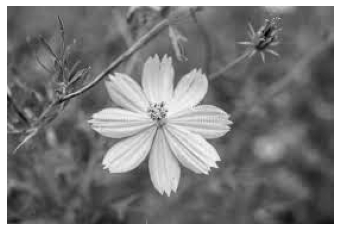

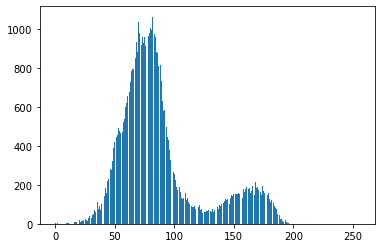

In [47]:
# Load the image
img = cv2.imread(IMG_PATH, 0)
img_histogram = histogram(img)
# Display the image
show_image(img)
# Plot the histogram
plot_histogram(img_histogram)

---

### 1. Segmentar com Limiar adaptativo (1 limiar)

Text(0.5, 1.0, '2. Imagem binarizada com a intensidade média')

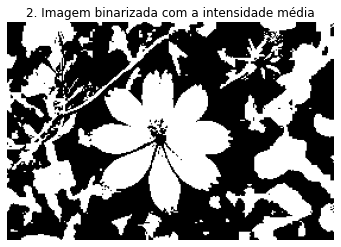

In [48]:
# 1 - Inicialize o limiar T como a média das intensidades;
n_pixels = (img.shape[0]*img.shape[1])
# T = np.sum([i*img_histogram[i] for i in range(256)])/n_pixels
bin_img = cv2.adaptiveThreshold(
    img, # Imagem em int8 com 1 canal
    255, # Valor máximo
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # Algoritmo
    cv2.THRESH_BINARY, # Tipo de threshold
    199, # Tamanho do bloco
    1) # Constante subtraida da media
# print(f'1. Intensidade média: {T}')
# 2 - Binarize a Imagem de Entrada I usando o limiar T
# bin_img = apply_threshold(img, [T])
show_image(bin_img)
plt.title("2. Imagem binarizada com a intensidade média")
# 3 - Calcule o novo limiar 

---

### 2. Segmentar com Entropia Clássica (1 limiar)

Resultado: 
  - Entropia = 8.54078;
  - Threshold = 102


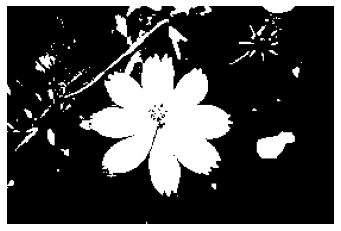

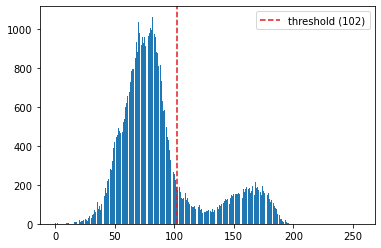

In [49]:
def shannon_entropy(hist):
    if sum(hist) == 0:
        return 0
    # Normaliza o histograma (transforma em uma funcao densidade de probabilidade)
    pdf = hist/sum(hist)
    # Prepara a parte interna do somatório aplicado no calculo da entropia
    func = lambda probability: probability*np.log(probability) if probability > 0 else 0
    # Calcula a entropia
    return -np.sum(np.vectorize(func)(pdf))

best_threshold = {
    'entropy': -1,
    'intensity': None
}
for i in range(1,255): # Inicio em dois pois nos slices do python o valor antes dos : não é inclusivo (ex :2 significa todos os valores até o indice 1)
    # Divide o histograma em dois
    hist_A = img_histogram[:i]
    hist_B = img_histogram[i:]
    # Calcula a entropia de cada trecho e depois a entropia total (soma das duas)
    entropy_A = shannon_entropy(hist_A)
    entropy_B = shannon_entropy(hist_B)
    total_entropy = entropy_A + entropy_B
    # Caso a entropia total seja a maior até agora, salva ela junto ao threshold
    if total_entropy > best_threshold['entropy']:
        best_threshold['entropy'] = total_entropy
        best_threshold['intensity'] = i

print(f"Resultado: \n  - Entropia = {best_threshold['entropy']:.5f};\n  - Threshold = {best_threshold['intensity']}")
show_image(apply_threshold(img, [best_threshold['intensity']]))
plot_histogram(img_histogram, thresholds=[best_threshold['intensity']])

---

### 4 - Segmentar com K-means (limiar)

Ponto(s) de corte escolhido(s): 115.13949678278985


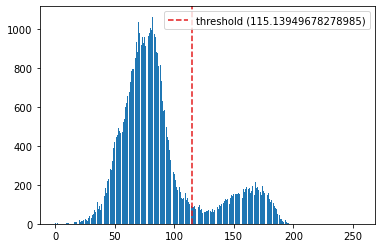

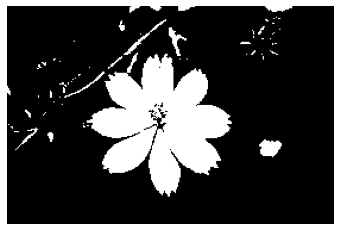

In [50]:
# Carrega o modelo pré implementado do kmeans pela biblioteca scikit-learn
kmeans_model = KMeans(n_clusters=2)
# Fit 2 clusters and find the threashold as the divisory line between them
pixel_labels = kmeans_model.fit_predict(img.reshape(-1,1))
kmeans_threshold = (kmeans_model.cluster_centers_[0][0]+kmeans_model.cluster_centers_[1][0])/2
# Display the result
print(f"Ponto(s) de corte escolhido(s): {kmeans_threshold}")
plot_histogram(img_histogram, thresholds=[kmeans_threshold])
show_image(apply_threshold(img, [kmeans_threshold]))

---

### 5 - Segmentar com Entropia Não-Extensiva (1 limiar) usando três valores para q: 1 menor que 1, outro maior que 1, e outro próximo de 1, p.e. 0.999 ou 1.0001

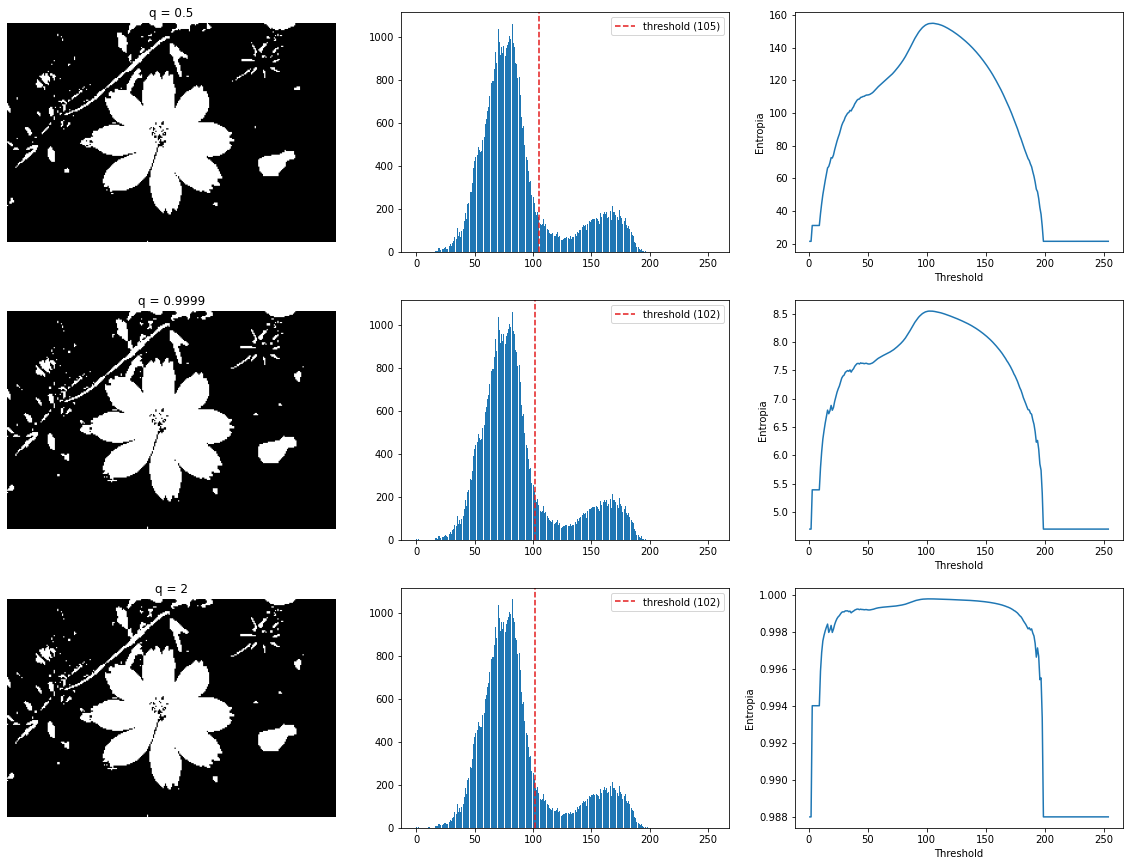

In [51]:
from dit import Distribution
from dit.other import tsallis_entropy

def img_tsallis_entropy(img_histogram, q, verbose=False):
    entropies = {}
    for i in range(1,255): # Inicio em dois pois nos slices do python o valor antes dos : não é inclusivo (ex :2 significa todos os valores até o indice 1)
        # Divide o histograma em dois
        hist_A = img_histogram[:i]
        hist_B = img_histogram[i:]
        # Funcao Distribuicao de Probabilidade
        if sum(hist_A) > 0:
            # Gera a distribuicao do histograma, necessario apenas para usar a biblioteca
            pdf_A = (hist_A/sum(hist_A))
            # Encontra a entropia maxima (q=0)
            dist_A = Distribution({f'{i:08b}': pdf_A[i] for i in range(len(pdf_A))})
            # Encontra a entropia para o q fornecido (em cada lado)
            #Smax_A = tsallis_entropy(dist_A, 0)
            # Encontra a entropia total
            entropy_A = tsallis_entropy(dist_A, q)
            entropy_A = entropy_A if not np.isnan(entropy_A) else 0
        else:
            entropy_A = 0
        if sum(hist_B) > 0:
            pdf_B = (hist_B/sum(hist_B))
            dist_B = Distribution({f'{i:08b}': pdf_B[i] for i in range(len(pdf_B))})
            #Smax_B = tsallis_entropy(dist_B, 0)
            entropy_B = tsallis_entropy(dist_B, q)
            entropy_B = entropy_B if not np.isnan(entropy_B) else 0
        else:
            entropy_B = 0
        entropies[i] = entropy_A + entropy_B + (1-q)*entropy_A*entropy_B
        if verbose:
            # Imprime uma tabela de valores
            print(f"q = {q:<3} | i = {i:<3} | S(A) = {entropy_A:<8.5f} | S(B) = {entropy_B:.5f} | Sq = {entropies[i]:.5f}")
    # Filtra valores nan (resultados de divisao por zero)
    # entropies = {key: value for key, value in entropies.items() if not np.isnan(value)}
    # Encontra o melhor threshold (menor entropia total)
    best_threshold = max(entropies, key=entropies.get)
    if verbose:
        print(f"Resultado (q={q}): \n  - Entropia = {entropies[best_threshold]:.5f};\n  - Threshold = {best_threshold}")
    return (best_threshold, entropies)

fig, axs = plt.subplots(
    3, # Rows
    3, # Cols
    figsize=(20,15))
for q, ax in zip((0.5, 0.9999, 2), axs):
    best_threshold, entropies = img_tsallis_entropy(img_histogram, q, False)
    ax[0].set_title(f"q = {q}")
    show_image(apply_threshold(img, thresholds=[best_threshold]), ax=ax[0])
    plot_histogram(img_histogram, thresholds=[best_threshold], ax=ax[1])
    ax[2].plot(entropies.keys(), entropies.values())
    ax[2].set_xlabel("Threshold")
    ax[2].set_ylabel("Entropia")

---

### 6 - Segmentar com Entropia Não-Extensiva (2 limiares). Os valores de q iguais ao da questão 5

KeyboardInterrupt: 

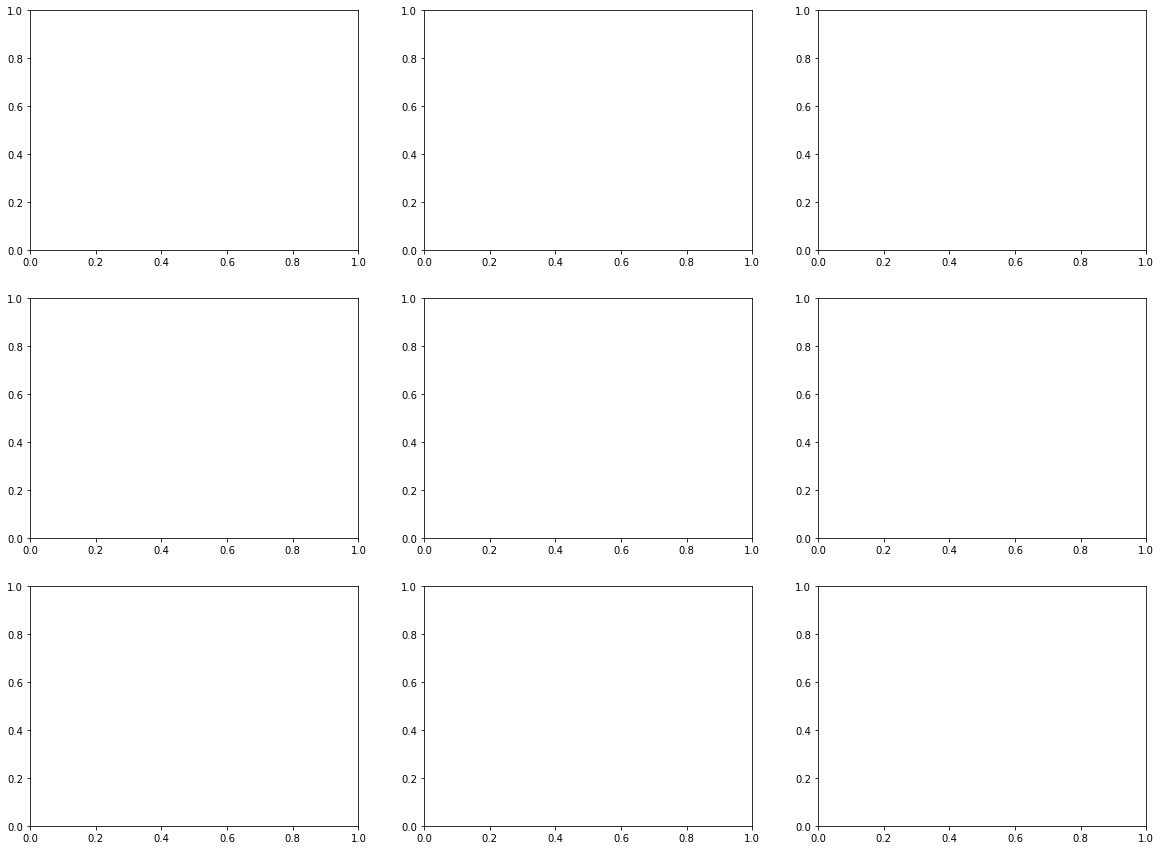

In [52]:
def img_tsallis_entropy(img_histogram, q, verbose=False):
    entropies = {}
    for i in range(1,254): # Inicio em dois pois nos slices do python o valor antes dos : não é inclusivo (ex :2 significa todos os valores até o indice 1)
        for j in range(i, 255):
            # Divide o histograma em dois
            hist_A = img_histogram[:i]
            hist_B = img_histogram[i:j]
            hist_C = img_histogram[j:]
            # Funcao Distribuicao de Probabilidade
            if sum(hist_A) > 0:
                # Gera a distribuicao do histograma, necessario apenas para usar a biblioteca
                pdf_A = (hist_A/sum(hist_A))
                # Encontra a entropia maxima (q=0)
                dist_A = Distribution({f'{i:08b}': pdf_A[i] for i in range(len(pdf_A))})
                # Encontra a entropia para o q fornecido (em cada lado)
                #Smax_A = tsallis_entropy(dist_A, 0)
                # Encontra a entropia total
                entropy_A = tsallis_entropy(dist_A, q)
                entropy_A = entropy_A if not np.isnan(entropy_A) else 0
            else:
                entropy_A = 0
            if sum(hist_B) > 0:
                pdf_B = (hist_B/sum(hist_B))
                dist_B = Distribution({f'{i:08b}': pdf_B[i] for i in range(len(pdf_B))})
                #Smax_B = tsallis_entropy(dist_B, 0)
                entropy_B = tsallis_entropy(dist_B, q)
                entropy_B = entropy_B if not np.isnan(entropy_B) else 0
            else:
                entropy_B = 0
            if sum(hist_C) > 0:
                pdf_C = (hist_C/sum(hist_C))
                dist_C = Distribution({f'{i:08b}': pdf_C[i] for i in range(len(pdf_C))})
                #Smax_C = tsallis_entropy(dist_C, 0)
                entropy_C = tsallis_entropy(dist_C, q)
                entropy_C = entropy_C if not np.isnan(entropy_C) else 0
            else:
                entropy_C = 0
            idx = f'{i}/{j}'
            entropies[idx] = entropy_A + entropy_B + (1-q)*entropy_A*entropy_B
            entropies[idx] = entropies[idx] + entropy_C + (1-q)*entropies[idx]*entropy_C
            if verbose:
                # Imprime uma tabela de valores
                print(f"q = {q:<3} | i = {i:<3} | j = {j:<3} | S(A) = {entropy_A:<8.5f} | S(B) = {entropy_B:.5f} | S(C) = {entropy_C:.5f} | Sq = {entropies[i]:.5f}")
    # Filtra valores nan (resultados de divisao por zero)
    # entropies = {key: value for key, value in entropies.items() if not np.isnan(value)}
    # Encontra o melhor threshold (menor entropia total)
    best_thresholds = max(entropies, key=entropies.get)
    if verbose:
        print(f"Resultado (q={q}): \n  - Entropia = {entropies[best_thresholds]:.5f};\n  - Threshold = {best_thresholds}")
    return (best_thresholds, entropies)

fig, axs = plt.subplots(
    3, # Rows
    3, # Cols
    figsize=(20,15))
for q, ax in zip((0.5, 0.9999, 2), axs):
    best_thresholds, entropies = img_tsallis_entropy(img_histogram, q, False)
    best_threshold_value = list(map(int, best_thresholds.split('/')))
    ax[0].set_title(f"q = {q}")
    show_image(apply_threshold(img, [best_threshold_value]), ax=ax[0])
    plot_histogram(img_histogram, thresholds=[best_threshold_value[0]], ax=ax[1])
    # ax[2].plot(entropies.keys(), entropies.values())
    # ax[2].set_xlabel("Threshold")
    # ax[2].set_ylabel("Entropia")

---

### 7 - Use os métodos  de  segmentação das questões  1 a  6 para isolar  para  isolar uma  região de interesse de uma imagem que você escolheu

In [224]:
test_images = []

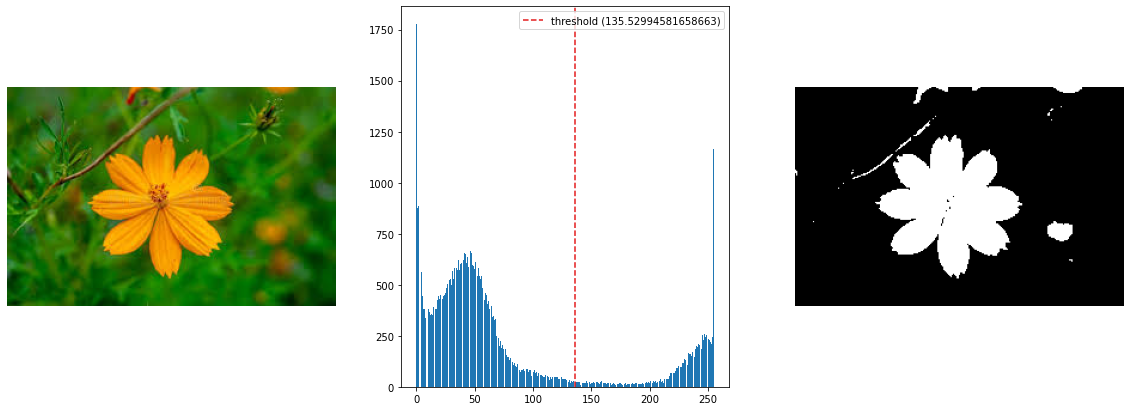

In [225]:
NATURE_IMG_PATH = './images/test_image.jpg'
fig, ax = plt.subplots(1,3, figsize=(20,7))
# Load the image
nature_img_original = cv2.cvtColor(cv2.imread(NATURE_IMG_PATH), cv2.COLOR_BGR2RGB)
show_image(nature_img_original, ax=ax[0], rgb=True)
# Get only the green red channel (better than converting to grayscale for segmenting this image)
nature_img = nature_img_original[:,:,0]
nature_img_histogram = histogram(nature_img)
# Apply kmeans
kmeans_model = KMeans(n_clusters=2)
pixel_labels = kmeans_model.fit_predict(nature_img.reshape(-1,1))
kmeans_threshold = (kmeans_model.cluster_centers_[0][0]+kmeans_model.cluster_centers_[1][0])/2
# kmeans_threshold2 = (kmeans_model.cluster_centers_[1][0]+kmeans_model.cluster_centers_[2][0])/2
thresholds = [kmeans_threshold]#, kmeans_threshold2)
nature_img_mask = apply_threshold(nature_img, thresholds, reversed=False)
# Display
plot_histogram(nature_img_histogram, thresholds, ax[1])
show_image(nature_img_mask, ax[2])
test_images.append({
    'original': nature_img_original,
    'single-channel': nature_img,
    'histogram': nature_img_histogram,
    'thresholds': thresholds,
    'mask': nature_img_mask
})


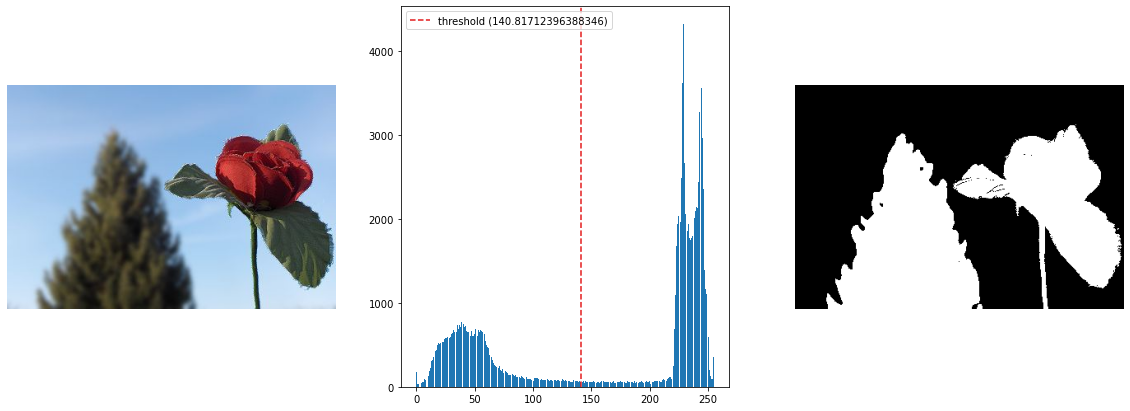

In [226]:
NATURE_IMG_PATH = './images/_test_image.jpg'
fig, ax = plt.subplots(1,3, figsize=(20,7))
# Load the image
nature_img_original = cv2.cvtColor(cv2.imread(NATURE_IMG_PATH), cv2.COLOR_BGR2RGB)
show_image(nature_img_original, ax=ax[0], rgb=True)
# Get only the green red channel (better than converting to grayscale for segmenting this image)
nature_img = nature_img_original[:,:,2]
nature_img_histogram = histogram(nature_img)
# Apply kmeans
kmeans_model = KMeans(n_clusters=2)
pixel_labels = kmeans_model.fit_predict(nature_img.reshape(-1,1))
kmeans_threshold = (kmeans_model.cluster_centers_[0][0]+kmeans_model.cluster_centers_[1][0])/2
# kmeans_threshold2 = (kmeans_model.cluster_centers_[1][0]+kmeans_model.cluster_centers_[2][0])/2
thresholds = [kmeans_threshold]#, kmeans_threshold2)
nature_img_mask = apply_threshold(nature_img, thresholds, reversed=True)
# Display
plot_histogram(nature_img_histogram, thresholds, ax[1])
show_image(nature_img_mask, ax[2])
test_images.append({
    'original': nature_img_original,
    'single-channel': nature_img,
    'histogram': nature_img_histogram,
    'thresholds': thresholds,
    'mask': nature_img_mask,
})


---

### 8 - Aplique  erosão combinada  com  dilatação  para  extrair  a  região  de  interesse  do  item  7

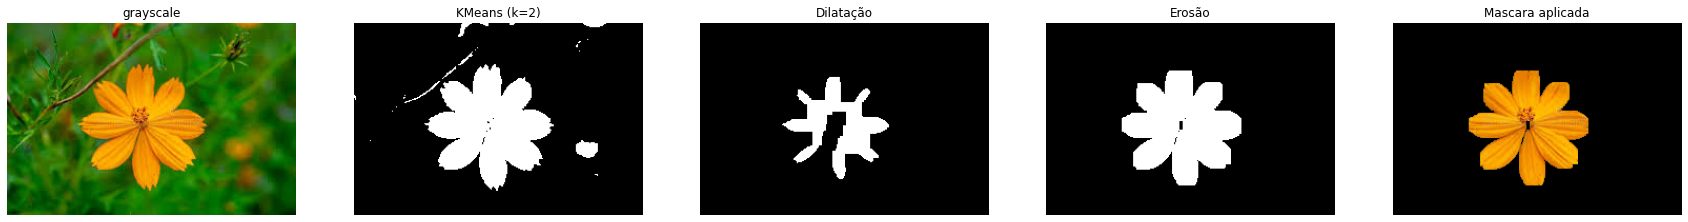

In [227]:
fig, ax = plt.subplots(1,5, figsize=(30,20))
# Kernel usado na closing (dilatacao + erosao)
kernel = np.ones((3, 3), np.uint8)
data = test_images[0]

ax[0].set_title('grayscale')
show_image(data['original'], ax[0])
ax[1].set_title('KMeans (k=2)')
show_image(data['mask'], ax[1])
ax[3].set_title('Erosão')
data['mask'] = cv2.erode(data['mask'], kernel, iterations=6)
show_image(data['mask'], ax=ax[2])
ax[2].set_title('Dilatação')
data['mask'] = cv2.dilate(data['mask'], kernel, iterations=6)
show_image(data['mask'], ax=ax[3])
masked_img = cv2.bitwise_and(data['original'],data['original'],mask = data['mask'])
ax[4].set_title('Mascara aplicada')
show_image(masked_img, ax=ax[4])

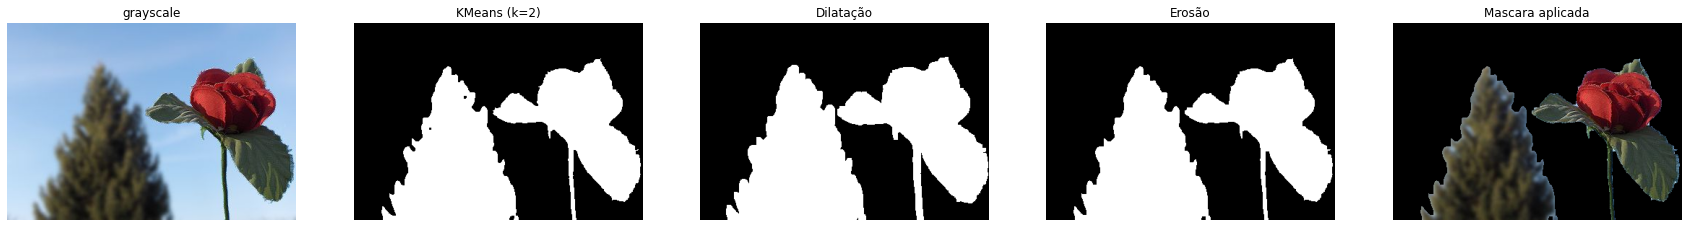

In [230]:
fig, ax = plt.subplots(1,5, figsize=(30,20))
# Kernel usado na closing (dilatacao + erosao)
kernel = np.ones((3, 3), np.uint8)
data = test_images[1]

ax[0].set_title('grayscale')
show_image(data['original'], ax[0])
ax[1].set_title('KMeans (k=2)')
show_image(data['mask'], ax[1])
ax[2].set_title('Dilatação')
data['mask'] = cv2.dilate(data['mask'], kernel, iterations=2)
show_image(data['mask'], ax=ax[2])
ax[3].set_title('Erosão')
data['mask'] = cv2.erode(data['mask'], kernel, iterations=2)
show_image(data['mask'], ax=ax[3])
masked_img = cv2.bitwise_and(data['original'],data['original'],mask = data['mask'])
ax[4].set_title('Mascara aplicada')
show_image(masked_img, ax=ax[4])

### 

---

### 9 - Encontre as coordenadas da borda da imagem

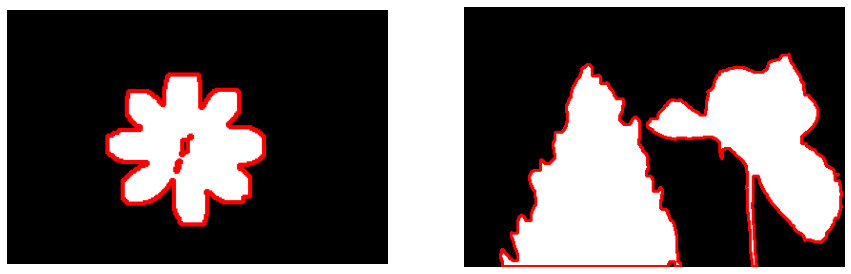

In [235]:
fig, ax = plt.subplots(1, len(test_images), figsize=(15,10))
for i, data in enumerate(test_images):
    contours, hierarchy = cv2.findContours(data['mask'], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    nature_img_contours = cv2.drawContours(cv2.cvtColor(data['mask'],cv2.COLOR_GRAY2RGB), contours, -1, (255, 0, 0), 2)
    show_image(nature_img_contours, ax=ax[i])

---

### 10 - Repita os itens 1 a 8 com outra imagem semelhante, mas diferente da usada no item 9

* Junto ao código anterior

---

### 11 - Com  as  curvas  das  regiões  obtidas  nas  questões  9  e  10,  calcule  as  distâncias  PDM, Hounsdorff, Distância Euclidiana e Vetorial entre as duas curvas.

---

### 12 - 

In [236]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

hist = test_images[0]['original']